### Deep Learning - Final Project ###
#### Amy Schneider & Alonna Guerrero ####

# Acute Lymphoblastic Leukemia Blood Smear Image Analysis
## Introduction
The C-NMC dataset is data from the IEEE International Symposium on Biomedical Imaging and was originally part of a challenge at the conference and was found on Kaggle [here.](https://www.kaggle.com/code/behcetsenturk/leukemia-classification-from-cell-images) The data provides images of blood cells, some of which are positive for Acute Lymphoblastic Leukemia, or ALL, as well as normal blood cells. The challenge details specifically note that distinguishing ALL cells from normal cells is difficult as "cell types appear similar under the microscope and subject-level variability plays a key role." The training data has been reviewed by an expert and ALL cells are placed in files with the suffix "all," while normal cells are in files with the "hem" suffix (in pathology, "hem" means blood), which serve as the ground truth labels.

Our aim with this dataset is to build a model that can distinguish between healthy and ALL cells with maximum accuracy and precision.  Image recognition problems such as this can aid pathologists and oncologists in screening samples, but also in decision-making, and help provide quicker and more accurate diagnoses in order to allow those diagnosed with ALL quicker access to potentially lifesaving treatment.

We start by loading necessary packages for analysis, utilizing Google Drive storage for the image files and connection to them from this notebook, or directly load them from our device, depending on the computational needs of the cell.

In [14]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
import zipfile
from concurrent.futures import ThreadPoolExecutor

In [48]:
# user = 'Alonna'
# if user == 'Alonna':
#   from google.colab import drive
#   drive.mount('/content/drive')

## Data Exploration and Loading
Our next task is to navigate the folders within the zipped file to pull all the relevant images into a combined and manageable dataset for analysis.

In [15]:
## Code for directly unzipping and running from machine
## Ensure that you have the .zip file in the same folder that you run this notebook in

# Specify the path to the uploaded zip file
zip_file_path = 'C-NMC_Leukemia.zip'

# Specify the directory where you want to extract the contents
extract_dir = 'extracted_contents'

# Create a directory to extract the contents into
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files and directories
extracted_files = os.listdir(extract_dir)
print("Extracted files and directories:", extracted_files)

# Directory containing the extracted files
extracted_dir = os.path.join(extract_dir, 'C-NMC_Leukemia')

# List the contents of the C-NMC_Leukemia directory
leukemia_contents = os.listdir(extracted_dir)
print("Contents of C-NMC_Leukemia directory:", leukemia_contents)

Extracted files and directories: ['__MACOSX', 'C-NMC_Leukemia']
Contents of C-NMC_Leukemia directory: ['training_data', 'testing_data', '.DS_Store', 'validation_data']


In [16]:
# Define the directories
# if user == 'Alonna':
#   base_dir = '/content/drive/My Drive/C-NMC_Leukemia'
# else:
base_dir = 'extracted_contents/C-NMC_Leukemia'
training_dir = os.path.join(base_dir, 'training_data')
testing_dir = os.path.join(base_dir, 'testing_data')
validation_dir = os.path.join(base_dir, 'validation_data')

# Dictionary to store directories and files
all_entries = {
    'base_dir': base_dir,
    'training_dir': training_dir,
    'testing_dir': testing_dir,
    'validation_dir': validation_dir
}

# Function to recursively find subdirectories and files
def find_entries(directory):
    entries = os.listdir(directory)
    for entry in entries:
        entry_path = os.path.join(directory, entry)
        if os.path.isdir(entry_path):
            all_entries[entry] = entry_path
            find_entries(entry_path)
        else:
            if not entry.endswith('.bmp'):
                all_entries[entry] = entry_path

# Find entries for each directory
find_entries(training_dir)
find_entries(testing_dir)
find_entries(validation_dir)

# Display all directories and files found
print("All directories and files found:")
for key, value in all_entries.items():
    print(key, ":", value)


All directories and files found:
base_dir : extracted_contents/C-NMC_Leukemia
training_dir : extracted_contents/C-NMC_Leukemia/training_data
testing_dir : extracted_contents/C-NMC_Leukemia/testing_data
validation_dir : extracted_contents/C-NMC_Leukemia/validation_data
fold_2 : extracted_contents/C-NMC_Leukemia/training_data/fold_2
hem : extracted_contents/C-NMC_Leukemia/training_data/fold_1/hem
all : extracted_contents/C-NMC_Leukemia/training_data/fold_1/all
fold_0 : extracted_contents/C-NMC_Leukemia/training_data/fold_0
fold_1 : extracted_contents/C-NMC_Leukemia/training_data/fold_1
.DS_Store : extracted_contents/C-NMC_Leukemia/validation_data/.DS_Store
C-NMC_test_final_phase_data : extracted_contents/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data
C-NMC_test_prelim_phase_data : extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data
C-NMC_test_prelim_phase_data_labels.csv : extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_l

In [17]:
# Check to ensure the directories have correctly been uploaded
print("Directories uploaded successfully:")
print("Training directory:", os.path.isdir(training_dir))
print("Testing directory:", os.path.isdir(testing_dir))
print("Validation directory:", os.path.isdir(validation_dir))
print()

# Function to count files in a directory
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Display the number of files found in each directory
print("Number of files found in each directory:")
training_count = count_files(training_dir)
testing_count = count_files(testing_dir)
validation_count = count_files(validation_dir)
print("Training directory:", training_count)
print("Testing directory:", testing_count)
print("Validation directory:", validation_count)

# Calculate the total number of files
total_files = training_count + testing_count + validation_count

# Calculate the splits
training_split = training_count / total_files
validation_split = validation_count / total_files
testing_split = testing_count / total_files

print("\nOur dataset was pre-split with the following:")
print("\tTraining:", '{:.2%}'.format(training_split))
print("\tValidation:", '{:.2%}'.format(validation_split))
print("\tTesting:", '{:.2%}'.format(testing_split))

Directories uploaded successfully:
Training directory: True
Testing directory: True
Validation directory: True

Number of files found in each directory:
Training directory: 10661
Testing directory: 2587
Validation directory: 1869

Our dataset was pre-split with the following:
	Training: 70.52%
	Validation: 12.36%
	Testing: 17.11%


Above, we verified the integrity of the training, validation, and testing data directories, which are essential for training and evaluating our future models. We then examined the contents of each directory, revealing that the training data folder contains 10,498 files, while the testing and validation data folders contain 2,586 and 1,866 files, respectively. These directories have been structured to support our machine learning endeavors, with the training data serving as the foundation for model development. Following training, the validation and testing datasets will be employed to assess the model's performance. The calculated percentage splits—70.22% for training, 12.48% for validation, and 17.30% for testing—illustrate the distribution of data within our dataset, providing crucial insights for future model training and evaluation.

Next, we create a pandas DataFrame, which will allow us to store the label for each image (as identified by an expert - "hem" (or normal) and "all" (positive for the disease).  We will also store the path to the full image for use in the remainder of our analysis.

In [18]:
# List to store DataFrame Training Set (with each fold)
fold_files = []
labels = []

# Iterate over each fold
for fold_name in os.listdir(training_dir):
    fold_dir = os.path.join(training_dir, fold_name)

    # Iterate over each subfolder within the fold
    for subfolder in os.listdir(fold_dir):
        subfolder_dir = os.path.join(fold_dir, subfolder)

        # Create DataFrame for the images in the subfolder
        for f in os.listdir(subfolder_dir):
            filepath = os.path.join(subfolder_dir, f)
            fold_files.append(filepath)
            labels.append(subfolder)

        # # Append DataFrame for the current subfolder to the list
        # fold_dfs.append(subfolder_df)
print("Fold Files:", fold_files)
print("Labels:", labels)

# Combine data lists into single dataframe to be used in Training

df = pd.DataFrame(list(zip(fold_files, labels)), columns = ['filepath', 'label'])
print("Training Set:\n", df)

Fold Files: ['extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H40_13_3_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H40_21_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H4_5_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H18_6_5_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_19_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H13_3_4_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H40_24_10_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H46_5_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H20_28_3_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H5_11_3_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H1_20_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_15_2_hem.bmp

Upon further exploration of the test set data provided, we determined that no ground truth labels were assigned to the images.  After reviewing the initial challenge wesbite and details, we confirmed that the test set labels are not available online.  Because of that, we decided to use the data originally designated as validation data as our test dataset, and to later split the training set for training and validation.

Below we extracted the contents of the validation set and created a new DataFrame with a similar structure to the validation data.

In [19]:
# Load the test dataset, using validation_data files
# if user == 'Alonna':
#   df_test = pd.read_csv('/content/drive/My Drive/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
# else:
df_test = pd.read_csv('extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

print("Initial file:", df_test.head())

# Drop 'Patient_ID' column and rename columns
df_test['filepath'] = df_test['new_names']
df_test['label'] = df_test['labels']
df_test = df_test[['filepath', 'label']]

# Change image path from relative to full path
# if user == 'Alonna':
#   df_test['filepath'] = df_test['filepath'].apply(lambda x: '/content/drive/My Drive/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'+x)
# else:
df_test['filepath'] = df_test['filepath'].apply(lambda x: 'extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'+x)

# Validate existence of image files
df_test['file_exists'] = df_test['filepath'].apply(lambda x: os.path.isfile(x))

# Filter out rows where image files don't exist
df_test = df_test[df_test['file_exists']]

# Remove the 'file_exists' column
df_test = df_test.drop(columns=['file_exists'])

# Change label to have written values (to be changed prior to CNN)
df_test['label'] = df_test['label'].replace({1: "all", 0: "hem"})

print("\n Test df:\n", df_test.head())

Initial file:              Patient_ID new_names  labels
0   UID_57_29_1_all.bmp     1.bmp       1
1   UID_57_22_2_all.bmp     2.bmp       1
2   UID_57_31_3_all.bmp     3.bmp       1
3  UID_H49_35_1_hem.bmp     4.bmp       0
4   UID_58_6_13_all.bmp     5.bmp       1

 Test df:
                                             filepath label
0  extracted_contents/C-NMC_Leukemia/validation_d...   all
1  extracted_contents/C-NMC_Leukemia/validation_d...   all
2  extracted_contents/C-NMC_Leukemia/validation_d...   all
3  extracted_contents/C-NMC_Leukemia/validation_d...   hem
4  extracted_contents/C-NMC_Leukemia/validation_d...   all


## Explore Data and Images
We begin our analysis with an exploration of the training dataset that will be used to build our model.  First, we take a look at four randomly selected images.  Reviewing the images, it becomes very apparent the challenge in distinguishing healthy from cancerous blood cells. We can see that the margins for the cell itself are not necessarily a predictor of ALL as the top right cell that is labeled as a normal cell is mishapen, and further, that the bottom right cell labeled as ALL looks very similar to the top left normal cell (at least to my untrained eye).  We can also see that the blood cell images themselves have a lot of unused black space that does not contribute to the model.  We can consider cropping these images to conserve processing power and increase efficiency.

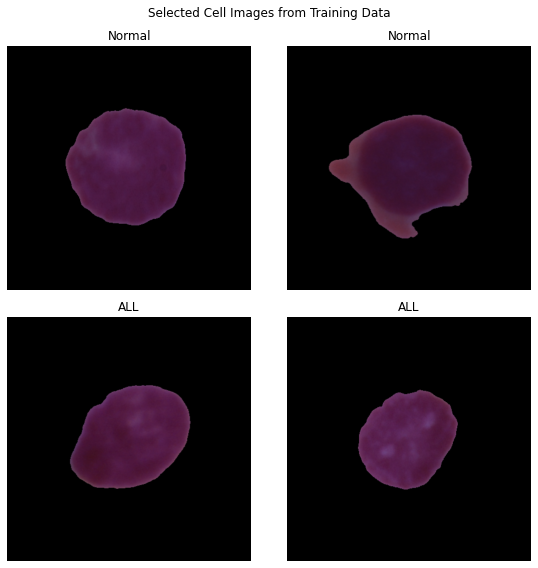

In [7]:
# Review randomly selected images and plot with appropriate labels

normal_image_1 = cv2.imread(df['filepath'][8])
normal_image_2 = cv2.imread(df['filepath'][99])
all_image_1 = cv2.imread(df['filepath'][2011])
all_image_2 = cv2.imread(df['filepath'][5000])

fig = plt.figure(figsize = (8,8))

fig.add_subplot(2,2,1)
plt.imshow(normal_image_1)
plt.axis('off')
plt.title('Normal')

fig.add_subplot(2,2,2)
plt.imshow(normal_image_2)
plt.axis('off')
plt.title('Normal')

fig.add_subplot(2,2,3)
plt.imshow(all_image_1)
plt.axis('off')
plt.title('ALL')

fig.add_subplot(2,2,4)
plt.imshow(all_image_2)
plt.axis('off')
plt.title('ALL')

plt.suptitle('Selected Cell Images from Training Data')
plt.tight_layout()
plt.show()

# Plot several random images from each label group

Next, we look at our DataFrame of images and labels.  We know from creating the DataFrame above, that the information on the images and patients is sparse.  We do not have demographic information such as age, gender, any symptoms, other test results, etc. that could serve as predictors to enhance our model.  The images themselves and their labels are the only data available to make a prediction.  When we created the DataFrame, we noted that there were 10,661 rows and 2 columns (image path and label).  Below we look at the distribution of labels within the data.

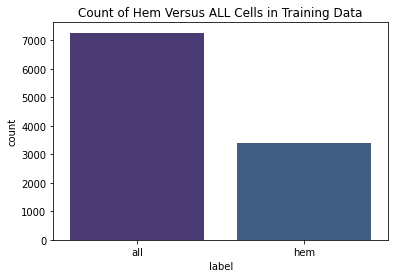

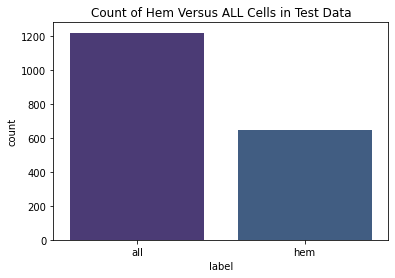

The distribution of cells labeled as 'hem' and 'ALL' within the training data is the following:
all    7272
hem    3389
Name: label, dtype: int64

The distribution of cells labeled as 'hem' and 'ALL' within the validation data is the following:
all    1219
hem     648
Name: label, dtype: int64

Hem to ALL ratio in the training data: 0.47
Hem to ALL ratio in the test data: 0.53


In [8]:
# Define the order of the bars
order = ["all", "hem"]

# We utilize a countplot from Seaborn to visualize how many samples we have of each label type
sns.set_palette('viridis')
sns.countplot(data=df, x='label', order=order).set_title("Count of Hem Versus ALL Cells in Training Data")
plt.show()

# To view comparable distribution in Test Set
sns.set_palette('viridis')
sns.countplot(data=df_test, x='label', order=order).set_title("Count of Hem Versus ALL Cells in Test Data")
plt.show()

print("The distribution of cells labeled as 'hem' and 'ALL' within the training data is the following:")
counts_train = df['label'].value_counts()
print(counts_train)

print("\nThe distribution of cells labeled as 'hem' and 'ALL' within the validation data is the following:")
counts_test = df_test['label'].value_counts()
print(counts_test)

hem_to_all_ratio_train = counts_train['hem'] / counts_train['all']
hem_to_all_ratio_val = counts_test['hem'] / counts_test['all']

print("\nHem to ALL ratio in the training data:", round(hem_to_all_ratio_train,2))
print("Hem to ALL ratio in the test data:", round(hem_to_all_ratio_val,2))

We can see from the plot above that the data is imbalanced and there are far more ALL cells than normal, or hem-labeled cells.  It appears to be roughly double the amount of diseased cells to normal cells.  We can consider data augmentation (using some sort of image manipulation on hem-labeled images) to increase the amount of normal cells our model is exposed to in order to balance the data.  First, let's quantify exactly how many we have of each label group.

We noticed significant blank space in our original images and sought to enhance our dataset quality, and improve our processing power, by cropping them. Cropping offers several benefits, including reducing data size, focusing on relevant features, improving performance, and enhancing model generalization. Our method involves multiple steps: reading images using OpenCV, converting them to grayscale, applying Otsu's thresholding to isolate foreground from background, extracting foreground regions, computing bounding boxes, and ultimately cropping the original images based on these boxes. Additionally, we've integrated optional resizing functionality to standardize cropped image dimensions. This systematic approach optimizes computational resource usage while retaining pertinent image details for subsequent analysis or modeling tasks.

In [9]:
# Function to crop images using
def read_and_crop_image(image_path, resize=False, image_size=(224, 224)):
    # Read image
    image = cv2.imread(image_path)

    # Convert Color System from BGR(Blue, Green, Red) to GRAY
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's Thresholding
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply threshold
    result = cv2.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))

    # Crop Image
    crop_img = image[mnx:mxx, mny:mxy, :]

    # Resize the image if specified
    if resize:
        resized_image = cv2.resize(crop_img, image_size)
    else:
        resized_image = crop_img

    return resized_image

After creating our function above to crop the images, we next apply the function in batches to both the training data and test datasets.  Cropping the images in batches allows us to efficiently process the images.

In [10]:
# Define a directory to save cropped images for training set
cropped_training = 'cropped_images_training'
os.makedirs(cropped_training, exist_ok=True)

# Batch size
batch_size = 100

# Function to process a batch of images
def process_batch(df, output_dir):
    results = []
    for index, image_path in df:
        cropped_image = read_and_crop_image(image_path)
        if cropped_image is not None:
            output_path = os.path.join(output_dir, f'cropped_images_training_{index}.jpg')
            cv2.imwrite(output_path, cropped_image)
            results.append((index, output_path))
    return results

# Process training batches concurrently using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Prepare data for processing
    batches = [(i, row['filepath']) for i, row in df.iterrows()]
    # Split data into batches
    batched_data = [batches[i:i + batch_size] for i in range(0, len(batches), batch_size)]
    # Process batches concurrently
    training_results = executor.map(lambda batch: process_batch(batch, cropped_training), batched_data)

# Update DataFrame with cropped image file paths
for batch_results in training_results:
    for index, cropped_image_path in batch_results:
        df.at[index, 'cropped_filepath'] = cropped_image_path

print("Training images cropped successfully and DataFrame updated!")
executor.shutdown()

Training images cropped successfully and DataFrame updated!


In [11]:
# Define a directory to save cropped images for validation set
cropped_test = 'cropped_images_test'
os.makedirs(cropped_test, exist_ok=True)

# Batch size
batch_size = 100

# Function to process a batch of images
def process_batch(batch, output_dir):
    results = []
    for index, image_path in batch:
        cropped_image = read_and_crop_image(image_path)
        if cropped_image is not None:
            output_path = os.path.join(output_dir, f'cropped_images_test_{index}.jpg')
            cv2.imwrite(output_path, cropped_image)
            results.append((index, output_path))
    return results

# Process validation batches concurrently using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Prepare data for processing
    batches = [(i, row['filepath']) for i, row in df_test.iterrows()]
    # Split data into batches
    batched_data = [batches[i:i + batch_size] for i in range(0, len(batches), batch_size)]
    # Process batches concurrently
    test_results = executor.map(lambda batch: process_batch(batch, cropped_test), batched_data)

# Update DataFrame with cropped image file paths
for batch_results in test_results:
    for index, cropped_image_path in batch_results:
        df_test.at[index, 'cropped_filepath'] = cropped_image_path

print("Test images cropped successfully and DataFrame updated!")
executor.shutdown()

Test images cropped successfully and DataFrame updated!


Below we randomly extract an image and compare the original image to the cropped image.

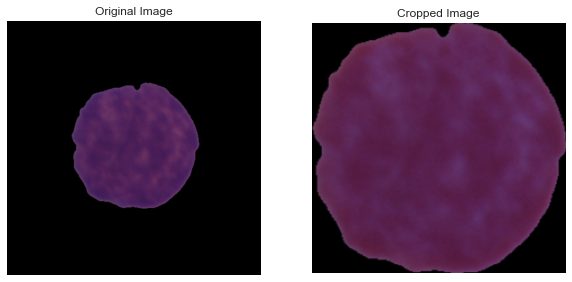

In [50]:
# Side by side view of an original image v cropped image

# Randomly select an image path from the DataFrame
random_image_path = np.random.choice(df['filepath'])

# Read the original image
original_image = cv2.imread(random_image_path)

# Display the original and cropped images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Read and crop the image
cropped_image = read_and_crop_image(random_image_path)

# Display cropped image
axes[1].imshow(cropped_image)
axes[1].set_title('Cropped Image')
axes[1].axis('off')

plt.show()

## Image Processing for Models

Below we complete several steps that are necessary for images to be analyzed by our deep learning models.  Thus far we have created DataFrames for the images with labels, both for training/validation sets and for test sets, cropped them, and added their path location to the original DataFrames.

Next, we save check for any missing values in our DataFrames to prevent errors when running our models, and then perform pre-processing measures necessary for running our deep learning models in Keras (Tensorflow).

In [13]:
# Check for null values in the cropped_filepath column (Training Set)
missing_values = df['cropped_filepath'].isnull().sum()

if missing_values == 0:
    print("All images were successfully cropped and added to the dataframe!")
else:
    print(f"There are {missing_values} images with missing cropped file paths. Please verify.")
    # Print rows with missing cropped file paths
    print("\nRows with missing cropped file paths:")
    print(df[df['cropped_filepath'].isnull()])

# Check in on Training df (optional)
print("Training Set:\n", df.head())

All images were successfully cropped and added to the dataframe!
Training Set:
                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
1  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
2  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
3  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
4  extracted_contents/C-NMC_Leukemia/training_dat...   hem   

                                    cropped_filepath  
0  cropped_images_training/cropped_images_trainin...  
1  cropped_images_training/cropped_images_trainin...  
2  cropped_images_training/cropped_images_trainin...  
3  cropped_images_training/cropped_images_trainin...  
4  cropped_images_training/cropped_images_trainin...  


In [14]:
# Check for null values in the cropped_filepath column (Validation Set)

missing_values = df_test['cropped_filepath'].isnull().sum()

if missing_values == 0:
    print("All images were successfully cropped and added to the dataframe!")
else:
    print(f"There are {missing_values} images with missing cropped file paths. Please verify.")
    # Print rows with missing cropped file paths
    print("\nRows with missing cropped file paths:")
    print(df_test[df_test['cropped_filepath'].isnull()])

# Check in on Validation df (optional)
print("\Test Set:\n", df_test.head())

All images were successfully cropped and added to the dataframe!
\Test Set:
                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/validation_d...   all   
1  extracted_contents/C-NMC_Leukemia/validation_d...   all   
2  extracted_contents/C-NMC_Leukemia/validation_d...   all   
3  extracted_contents/C-NMC_Leukemia/validation_d...   hem   
4  extracted_contents/C-NMC_Leukemia/validation_d...   all   

                                cropped_filepath  
0  cropped_images_test/cropped_images_test_0.jpg  
1  cropped_images_test/cropped_images_test_1.jpg  
2  cropped_images_test/cropped_images_test_2.jpg  
3  cropped_images_test/cropped_images_test_3.jpg  
4  cropped_images_test/cropped_images_test_4.jpg  


In [15]:
# Function to preprocess images using TensorFlow
def preprocess_image(filepath, image_size=(244, 244)):
    try:
        # Read image
        image = tf.io.read_file(filepath)
        # Decode image
        image = tf.image.decode_jpeg(image, channels=3)
        # Resize image to desired dimensions
        image = tf.image.resize(image, image_size)
        # Normalize pixel values to [0, 1]
        image = tf.cast(image, tf.float32) / 255.0
        return image
    except Exception as e:
        print(f"Error processing image {filepath}: {e}")
        return None

# List to store preprocessed images
preprocessed_images = []

# Preprocess images in batches
batch_size = 100
num_images = len(df['cropped_filepath'])
num_batches = (num_images + batch_size - 1) // batch_size

print("Total number of images:", num_images)
print("Batch size:", batch_size)
print("Number of batches:", num_batches)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_images)
    batch_filepaths = df['cropped_filepath'][start_idx:end_idx]

    batch_preprocessed_images = []
    print(f"Processing batch {i+1}/{num_batches}...")
    for idx, filepath in enumerate(batch_filepaths):
        preprocessed_image = preprocess_image(filepath)
        if preprocessed_image is not None:
            batch_preprocessed_images.append(preprocessed_image)
        print(f"Processed image {start_idx + idx + 1}/{num_images}", end="\r")

    # Convert list of preprocessed images to TensorFlow tensor
    batch_preprocessed_images = tf.convert_to_tensor(batch_preprocessed_images)
    preprocessed_images.append(batch_preprocessed_images)

print("\nAll images preprocessed successfully!")


Total number of images: 10661
Batch size: 100
Number of batches: 107
Processing batch 1/107...
Processing batch 2/107...
Processing batch 3/107...
Processing batch 4/107...
Processing batch 5/107...
Processing batch 6/107...
Processing batch 7/107...
Processing batch 8/107...
Processing batch 9/107...
Processing batch 10/107...
Processing batch 11/107...
Processing batch 12/107...
Processing batch 13/107...
Processing batch 14/107...
Processing batch 15/107...
Processing batch 16/107...
Processing batch 17/107...
Processing batch 18/107...
Processing batch 19/107...
Processing batch 20/107...
Processing batch 21/107...
Processing batch 22/107...
Processing batch 23/107...
Processing batch 24/107...
Processing batch 25/107...
Processing batch 26/107...
Processing batch 27/107...
Processing batch 28/107...
Processing batch 29/107...
Processing batch 30/107...
Processing batch 31/107...
Processing batch 32/107...
Processing batch 33/107...
Processing batch 34/107...
Processing batch 35/10

In [16]:
# List to store preprocessed images for test set
preprocessed_images_test = []

# Preprocess images in batches for test set
num_images_test = len(df_test['cropped_filepath'])
num_batches_test = (num_images_test + batch_size - 1) // batch_size

print("Total number of images in test set:", num_images_test)
print("Batch size:", batch_size)
print("Number of batches:", num_batches_test)

for i in range(num_batches_test):
    start_idx_test = i * batch_size
    end_idx_test = min((i + 1) * batch_size, num_images_test)
    batch_filepaths_test = df_test['cropped_filepath'][start_idx_test:end_idx_test]

    batch_preprocessed_images_test = []
    print(f"Processing test batch {i+1}/{num_batches_test}...")
    for idx, filepath_test in enumerate(batch_filepaths_test):
        preprocessed_image_test = preprocess_image(filepath_test)
        if preprocessed_image_test is not None:
            batch_preprocessed_images_test.append(preprocessed_image_test)
        print(f"Processed test image {start_idx_test + idx + 1}/{num_images_test}", end="\r")

    # Convert list of preprocessed images to TensorFlow tensor
    batch_preprocessed_images_test = tf.convert_to_tensor(batch_preprocessed_images_test)
    preprocessed_images_test.append(batch_preprocessed_images_test)

print("\nAll test images preprocessed successfully!")


Total number of images in test set: 1867
Batch size: 100
Number of batches: 19
Processing test batch 1/19...
Processing test batch 2/19...
Processing test batch 3/19...
Processing test batch 4/19...
Processing test batch 5/19...
Processing test batch 6/19...
Processing test batch 7/19...
Processing test batch 8/19...
Processing test batch 9/19...
Processing test batch 10/19...
Processing test batch 11/19...
Processing test batch 12/19...
Processing test batch 13/19...
Processing test batch 14/19...
Processing test batch 15/19...
Processing test batch 16/19...
Processing test batch 17/19...
Processing test batch 18/19...
Processing test batch 19/19...
Processed test image 1867/1867
All test images preprocessed successfully!


Next, we save the DataFrames as CSV to preserve data integrity and in order to allow us to execute the cells below without re-running the image cropping portion of the code as we worked on the data over the course of multiple days.

In [17]:
# Specify the paths where you want to save the CSV files
train_validate_file_path = 'train_validate.csv'
test_file_path = 'test.csv'

# Save the DataFrames as CSV files
df.to_csv(train_validate_file_path, index=False)  # Set index=False to avoid saving row numbers as a column
df_test.to_csv(test_file_path, index=False)  # Set index=False to avoid saving row numbers as a column

print(f"Train/validate DataFrame saved as CSV at: {train_validate_file_path}")
print(f"Test DataFrame saved as CSV at: {test_file_path}")

Train/validate DataFrame saved as CSV at: train_validate.csv
Test DataFrame saved as CSV at: test.csv


## Deep Learning Modeling

We start by loading packages necessary and then use our CSV files and convert back to DataFrames in order for easy loading of the data as noted above.

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, ParameterGrid, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('train_validate.csv')
df_test = pd.read_csv('test.csv')

print("Train & Validate:", df.head())

print("\nTest:", df_test.head())

Train & Validate:                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
1  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
2  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
3  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
4  extracted_contents/C-NMC_Leukemia/training_dat...   hem   

                                    cropped_filepath  
0  cropped_images_training/cropped_images_trainin...  
1  cropped_images_training/cropped_images_trainin...  
2  cropped_images_training/cropped_images_trainin...  
3  cropped_images_training/cropped_images_trainin...  
4  cropped_images_training/cropped_images_trainin...  

Test:                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/validation_d...   all   
1  extracted_contents/C-NMC_Leukemia/validation_d...   all   
2  extracted_contents/C-NMC_Leukemia/validation_d...   all   
3  extracted_contents/C-

In [5]:
# Splitting into train and validate sets
train_validate, test = train_test_split(df, test_size=len(df_test), random_state=42)  # Using entire df_test for the test set
train, validate = train_test_split(train_validate, test_size=0.2, random_state=42)  

# Display general stats
print("Train set:")
print("Shape:", train.shape)
print("Percentage of total data:", len(train) / len(df) * 100, "%")
print("Distribution of labels:")
print(train['label'].value_counts(normalize=True))
print("\n")

print("Validation set:")
print("Shape:", validate.shape)
print("Percentage of total data:", len(validate) / len(df) * 100, "%")
print("Distribution of labels:")
print(validate['label'].value_counts(normalize=True))
print("\n")

print("Test set:")
print("Shape:", test.shape)
print("Percentage of total data:", len(test) / len(df) * 100, "%")
print("Distribution of labels:")
print(test['label'].value_counts(normalize=True))
print("\n")

Train set:
Shape: (7035, 3)
Percentage of total data: 65.9881812212738 %
Distribution of labels:
all    0.686709
hem    0.313291
Name: label, dtype: float64


Validation set:
Shape: (1759, 3)
Percentage of total data: 16.499390301097456 %
Distribution of labels:
all    0.659466
hem    0.340534
Name: label, dtype: float64


Test set:
Shape: (1867, 3)
Percentage of total data: 17.51242847762874 %
Distribution of labels:
all    0.686127
hem    0.313873
Name: label, dtype: float64




In [6]:
# Define parameters
batch_size = 32
image_height = 224
image_width = 224

# Convert numerical labels to strings
train['label'] = train['label'].astype(str)
validate['label'] = validate['label'].astype(str)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255  # Rescale pixel values to the range [0, 1]
)

# Load cropped/preprocessed images for training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary",  # binary classification
)

# Load cropped/preprocessed images for validation set
validation_generator = datagen.flow_from_dataframe(
    dataframe=validate,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary",  # binary classification
)

# Load cropped/preprocessed images for test set
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary",  # binary classification
)

Found 7035 validated image filenames belonging to 2 classes.
Found 1759 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


### Pre-trainded model - ResNet50
We start our deep learning modeling with ResNet50, a commercially pre-trained model available in the Keras library. It is a convolutional neural network, or CNN, created to help address the vanishing gradient problem in deep learning, allowing the model to be trained very deep. ResNet was created by He, et al. in their paper, using the concept of residual learning. Residual learning uses shortcut connections, which is what allows it to avoid vanishing gradients. As you may be able to surmise, ResNet50 has 50 layers.

Below we import the baseline ResNet50 model, and then add additional layers on top to customize it for our data. We use similar layers to the ones we later use when we build our own CNN.

In [87]:
# Pre-Built Model For Comparison

resnet = ResNet50(weights='imagenet', include_top=False, pooling='max', input_shape = (224,224,3))
    # include_top=False excludes the fully connected layer at the top of the network

# Customize ResNet50 for our data (to be placed on top of base resnet model above)
x = resnet.output
x = Flatten()(x)
    # Add an additional layer that will help the pre-trained model learn our data
x = Dense(512, activation='relu')(x)
    # Add a final layer with 2 neurons (for our two classes) that uses a softmax function
predictions = Dense(1, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=predictions)
resnet_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])  # Monitor accuracy during training

resnet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

We fit our ResNet50 model to our data and then plot the accuracy and loss to better understand the model's performance.

In [90]:
# Fit ResNet50 Model with our data

history_resnet = resnet_model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
220/220 [==============================] - 1075s 5s/step - loss: 0.5365 - accuracy: 0.3133 - val_loss: 0.7065 - val_accuracy: 0.3405
Epoch 2/20
220/220 [==============================] - 1070s 5s/step - loss: 0.3216 - accuracy: 0.3133 - val_loss: 0.6912 - val_accuracy: 0.3405
Epoch 3/20
220/220 [==============================] - 1068s 5s/step - loss: 0.2815 - accuracy: 0.3133 - val_loss: 0.8239 - val_accuracy: 0.3405
Epoch 4/20
220/220 [==============================] - 1075s 5s/step - loss: 0.2413 - accuracy: 0.3133 - val_loss: 0.6750 - val_accuracy: 0.3405
Epoch 5/20
220/220 [==============================] - 1077s 5s/step - loss: 0.2406 - accuracy: 0.3133 - val_loss: 1.0305 - val_accuracy: 0.3405
Epoch 6/20
220/220 [==============================] - 1072s 5s/step - loss: 0.2357 - accuracy: 0.3133 - val_loss: 0.7712 - val_accuracy: 0.3405
Epoch 7/20
220/220 [==============================] - 1074s 5s/step - loss: 0.2019 - accuracy: 0.3133 - val_loss: 0.8260 - val_accuracy:

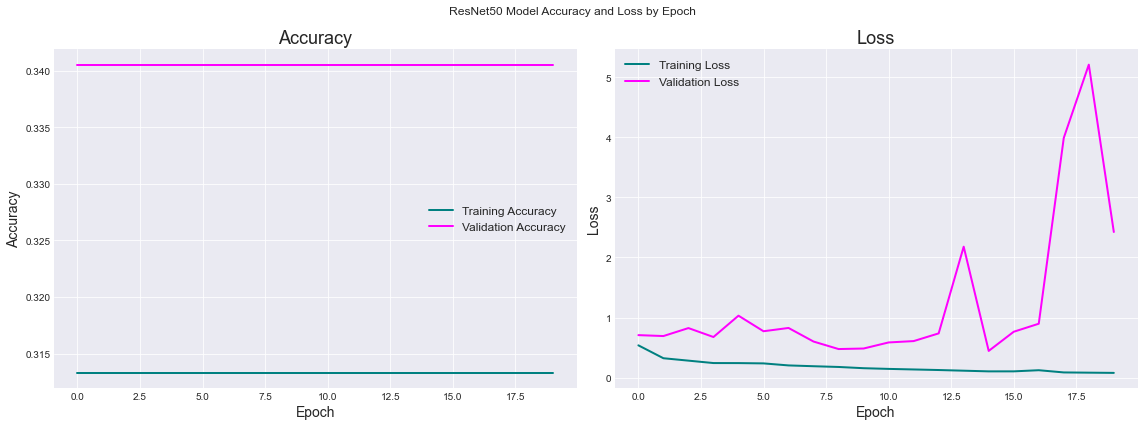

In [91]:
# Set the style
plt.style.use('seaborn-darkgrid')

# Create the plots
plt.figure(figsize=(16, 6))

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], color='teal', label='Training Accuracy', linewidth=2)
plt.plot(history_resnet.history['val_accuracy'], color='magenta', label='Validation Accuracy', linewidth=2)
plt.title('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], color='teal', label='Training Loss', linewidth=2)
plt.plot(history_resnet.history['val_loss'], color='magenta', label='Validation Loss', linewidth=2)
plt.title('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.suptitle('ResNet50 Model Accuracy and Loss by Epoch')

plt.tight_layout()
plt.show()


In [92]:
# Test Set
test_resnet_loss, test_resnet_accuracy = resnet_model.evaluate(test_generator)
print("Test Loss:", test_resnet_loss)
print("Test Accuracy:", test_resnet_accuracy)

59/59 [==============================] - 70s 1s/step - loss: 2.5359 - accuracy: 0.3471
Test Loss: 2.535919427871704
Test Accuracy: 0.34708088636398315


### Custom Built CNN Model

We next fit an initial CNN model using the Keras Sequential model, with alternating convolutional (using ReLU activation) and max pooling layers of three layers each, followed by a flattening layer and two dense, or fully connected layers

In [93]:
# Define model parameters
img_size = (224, 224, 3)  # Image size: 224x224 pixels with 3 channels (RGB)
num_classes = 2  # Number of classes: 2 for binary classification (Normal and Cancer)
batch_size = 32  # Define batch size

# Initial CNN Model
initial_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_size),  # Convolutional layer with ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Flatten(),  # Flatten layer to convert 2D feature maps to 1D feature vectors
    Dense(64, activation='relu'),  # Fully connected layer with ReLU activation
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the initial model
initial_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Display the initial model summary
initial_model.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_183 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_183 (MaxPool  (None, 111, 111, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_184 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_184 (MaxPool  (None, 54, 54, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_185 (Conv2D)         (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_185 (MaxPool  (None, 26, 26, 64)      

In [94]:
# Train our initial custom built model

history_initial = initial_model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
220/220 [==============================] - 120s 542ms/step - loss: 0.5972 - accuracy: 0.6977 - val_loss: 0.5833 - val_accuracy: 0.7038
Epoch 2/20
220/220 [==============================] - 119s 543ms/step - loss: 0.4990 - accuracy: 0.7683 - val_loss: 0.4834 - val_accuracy: 0.7692
Epoch 3/20
220/220 [==============================] - 119s 542ms/step - loss: 0.4259 - accuracy: 0.8199 - val_loss: 0.4209 - val_accuracy: 0.8056
Epoch 4/20
220/220 [==============================] - 119s 541ms/step - loss: 0.3849 - accuracy: 0.8344 - val_loss: 0.4006 - val_accuracy: 0.8181
Epoch 5/20
220/220 [==============================] - 119s 542ms/step - loss: 0.3574 - accuracy: 0.8526 - val_loss: 0.4262 - val_accuracy: 0.8039
Epoch 6/20
220/220 [==============================] - 119s 541ms/step - loss: 0.3152 - accuracy: 0.8726 - val_loss: 0.4565 - val_accuracy: 0.8204
Epoch 7/20
220/220 [==============================] - 119s 543ms/step - loss: 0.2810 - accuracy: 0.8854 - val_loss: 0.4192 -

Like our ResNet model, we examine the accuracy and loss of the initial CNN model below.

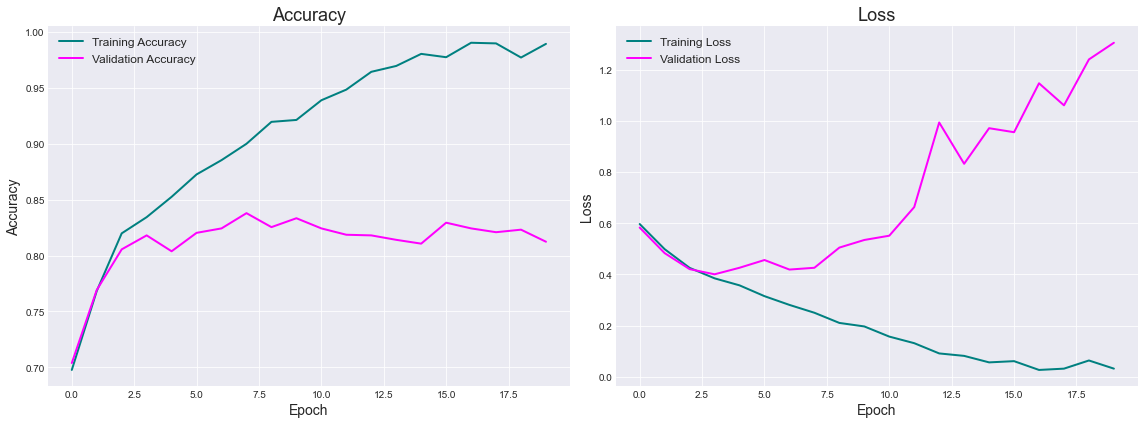

In [95]:
# Set the style
plt.style.use('seaborn-darkgrid')

# Create the plots
plt.figure(figsize=(16, 6))

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['accuracy'], color='teal', label='Training Accuracy', linewidth=2)
plt.plot(history_initial.history['val_accuracy'], color='magenta', label='Validation Accuracy', linewidth=2)
plt.title('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_initial.history['loss'], color='teal', label='Training Loss', linewidth=2)
plt.plot(history_initial.history['val_loss'], color='magenta', label='Validation Loss', linewidth=2)
plt.title('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
# from tabulate import tabulate
# import re

# # Calculate the best epochs
# best_epoch_acc_train = np.argmax(history_initial.history['accuracy']) + 1
# best_epoch_loss_train = np.argmin(history_initial.history['loss']) + 1
# best_epoch_acc_val = np.argmax(history_initial.history['val_accuracy']) + 1
# best_epoch_loss_val = np.argmin(history_initial.history['val_loss']) + 1

# # Store accuracy and loss information
# accuracy_data = []
# loss_data = []

# # Append headers
# accuracy_data.append(["Epoch", "Training Accuracy", "Validation Accuracy", "Accuracy Delta"])
# loss_data.append(["Epoch", "Training Loss", "Validation Loss", "Loss Delta"])

# # Append accuracy information
# for epoch, (train_acc, val_acc) in enumerate(zip(history_initial.history['accuracy'], history_initial.history['val_accuracy']), start=1):
#     delta = abs(train_acc - val_acc)
#     row = [epoch, train_acc, val_acc, delta]
#     accuracy_data.append(row)

# # Append loss information
# for epoch, (train_loss, val_loss) in enumerate(zip(history_initial.history['loss'], history_initial.history['val_loss']), start=1):
#     delta = abs(train_loss - val_loss)
#     row = [epoch, train_loss, val_loss, delta]
#     loss_data.append(row)

# # Find the smallest delta and highlight those epochs in green
# min_delta_acc = min(accuracy_data[1:], key=lambda x: float(x[3]))[3]
# min_delta_loss = min(loss_data[1:], key=lambda x: float(x[3]))[3]

# # Print side-by-side tables
# print(tabulate(accuracy_data, headers="firstrow", tablefmt="grid"), end="\n\n")
# print(tabulate(loss_data, headers="firstrow", tablefmt="grid"))


The plots show the training and validation accuracy and loss over 20 epochs. Initially, both training and validation accuracy increase, while the loss decreases, indicating that the model is learning. However, there seems to be overfitting as the training accuracy continues to increase, while the validation accuracy stagnates or decreases, and the validation loss increases. We will need to address overfitting concerns when improving our model.

In [96]:
# Evaluate the model on the test set
test_loss_initial, test_accuracy_initial = initial_model.evaluate(test_generator)
print("Test Loss:", test_loss_initial)
print("Test Accuracy:", test_accuracy_initial)

59/59 [==============================] - 9s 154ms/step - loss: 3.0995 - accuracy: 0.6626
Test Loss: 3.0994980335235596
Test Accuracy: 0.6625602841377258


The substantial difference between the test, validation, and training sets indicates potential overfitting in the model. While the test set results serve as a good starting point, the significant gaps between these accuracies underscore the need for improvement. To address overfitting, strategies such as regularization techniques, data augmentation, and hyperparameter tuning should be implemented. By iteratively refining the model, we can enhance its generalization performance and ensure it performs well on unseen data, thus strengthening its reliability and applicability.

### Model Improvement - Data Augmentation

To enhance the performance of our model, we recognized the need to rectify the imbalance within our dataset. Addressing this disparity is crucial as it ensures our model is trained on a comprehensive and evenly distributed dataset across all labels, particularly between 'hem' and 'all' categories. Employing data augmentation techniques allows us to amplify the representation of underrepresented classes, thereby fostering a more balanced and robust training environment for our model.

To address the imbalance in our dataset, we identified the difference in the number of 'hem' labeled images compared to other labels. Subsequently, we selected a corresponding number of 'hem' labeled images and augmented them by rotating them at angles of 90, 180, or 270 degrees. This process was implemented to rectify the unequal distribution of labels, thus enhancing the dataset's balance and ultimately improving the model's performance.

In [7]:
# Print the number of originally labeled images
num_original_hem_images = len(df[df['label'] == 'hem'])
num_original_all_images = len(df[df['label'] == 'all'])

print("Number of originally labeled 'hem' images:", num_original_hem_images)
print("Number of originally labeled 'all' images:", num_original_all_images)

# Calculate the difference between the counts
difference = abs(num_original_hem_images - num_original_all_images)

print("Difference between the counts:", difference)

# Filter the DataFrame to select only images labeled as 'hem'
hem_df = df[df['label'] == 'hem']

# Sample a subset of 'hem' images with the size equal to the difference between the counts
augmenting_df = hem_df.sample(n=difference, replace=True)

# Print the first few rows of the augmenting DataFrame
print("Number of 'hem' images selected for augmentation:", len(augmenting_df))
print(augmenting_df.head())

from PIL import Image
import os
import numpy as np
import random

# Define a function to rotate images and save them with new file paths
def rotate_images(df, angles=[90, 180, 270]):
    # Create the directory if it doesn't exist
    os.makedirs('augmented_images', exist_ok=True)
    
    # Initialize a list to store the new file paths
    new_filepaths = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Open the image using PIL
        image = Image.open(row['cropped_filepath'])
        # Convert the image to a numpy array
        image_array = np.array(image)
        # Randomly select an angle from the provided list
        angle = random.choice(angles)
        # Rotate the image
        rotated_image = np.rot90(image_array, k=int(angle / 90))
        # Save the rotated image with a new file path
        new_filepath = f"augmented_images/rotated_{angle}_{os.path.basename(row['cropped_filepath'])}"
        Image.fromarray(rotated_image).save(new_filepath)
        # Append the new file path to the list
        new_filepaths.append(new_filepath)

    # Add the list of new file paths as a new column in the DataFrame
    df['augmented_filepaths'] = new_filepaths

# Rotate the images in augmenting_df
rotate_images(augmenting_df)

# Display the DataFrame with new file paths
print(augmenting_df.head())

Number of originally labeled 'hem' images: 3389
Number of originally labeled 'all' images: 7272
Difference between the counts: 3883
Number of 'hem' images selected for augmentation: 3883
                                               filepath label  \
4359  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
8058  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
7123  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
7351  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
7800  extracted_contents/C-NMC_Leukemia/training_dat...   hem   

                                       cropped_filepath  
4359  cropped_images_training/cropped_images_trainin...  
8058  cropped_images_training/cropped_images_trainin...  
7123  cropped_images_training/cropped_images_trainin...  
7351  cropped_images_training/cropped_images_trainin...  
7800  cropped_images_training/cropped_images_trainin...  
                                               filepath label  \
4359  ext

In [8]:
# Replace the 'cropped_filepath' column with the 'augmented_filepaths' column
augmenting_df['cropped_filepath'] = augmenting_df['augmented_filepaths']

# Drop the 'augmented_filepaths' column as it's no longer needed
augmenting_df.drop(columns=['augmented_filepaths'], inplace=True)

# Concatenate the original DataFrame (df) with the augmented DataFrame (augmenting_df)
merged_df = pd.concat([df, augmenting_df], ignore_index=True)

# Count the labels in the merged DataFrame
label_counts = merged_df['label'].value_counts()

# Rename the original DataFrame (df) to old_df
old_df = df

# Concatenate the original DataFrame (old_df) with the augmented DataFrame (augmenting_df)
df = pd.concat([old_df, augmenting_df], ignore_index=True)

# Display the merged DataFrame
print(df.head())

                                            filepath label  \
0  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
1  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
2  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
3  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
4  extracted_contents/C-NMC_Leukemia/training_dat...   hem   

                                    cropped_filepath  
0  cropped_images_training/cropped_images_trainin...  
1  cropped_images_training/cropped_images_trainin...  
2  cropped_images_training/cropped_images_trainin...  
3  cropped_images_training/cropped_images_trainin...  
4  cropped_images_training/cropped_images_trainin...  


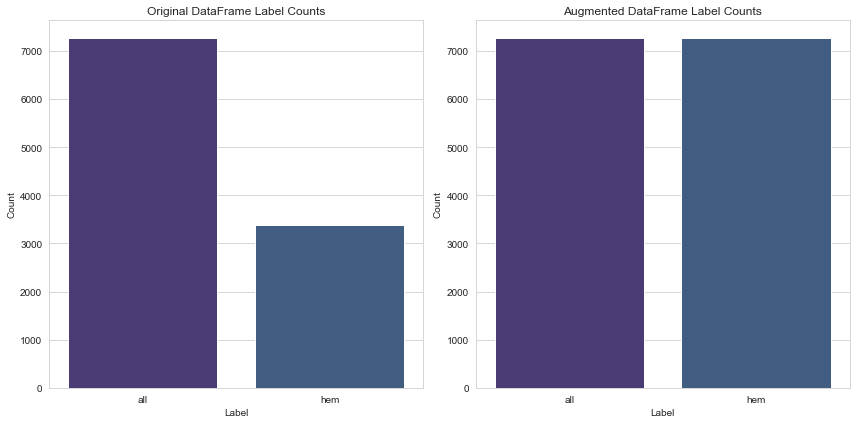

In [9]:
# Define the order of the bars
order = ["all", "hem"]

# Set the style and palette
sns.set_style("whitegrid")
sns.set_palette('viridis')

# Set up the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the counts of the old DataFrame
sns.countplot(data=old_df, x='label', order=order, ax=axes[0]).set_title("Original DataFrame Label Counts")
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# Plot the counts of the merged DataFrame
sns.countplot(data=df, x='label', order=order, ax=axes[1]).set_title("Augmented DataFrame Label Counts")
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

Following augmentation of our dataset, we re-split the data for model testing. Utilizing an ImageDataGenerator, we furhter augmented our data by load cropped images with differing variations, ensuring diverse training and validation datasets for a more robust model training.

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Re-Split the dataframe after augmentation for model improvement testing

# Use full df_test for Test
test = df_test

# Splitting into train and validate sets with an 85/15 split
train, validate = train_test_split(df, test_size=0.15, random_state=42)

# Display general stats
print("Train set:")
print("Shape:", train.shape)
print("Percentage of total data:", len(train) / (len(df)+len(df_test)) * 100, "%")
print("Distribution of labels:")
print(train['label'].value_counts(normalize=True))
print("\n")

print("Validation set:")
print("Shape:", validate.shape)
print("Percentage of total data:", len(validate) / (len(df)+len(df_test)) * 100, "%")
print("Distribution of labels:")
print(validate['label'].value_counts(normalize=True))
print("\n")

print("Test set (df_test):")
print("Shape:", test.shape)
print("Percentage of total data:", len(test) / (len(df)+len(df_test)) * 100, "%")
print("Distribution of labels:")
print(test['label'].value_counts(normalize=True))
print("\n")

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
)

# Load cropped/preprocessed images for training set with augmentation
train_generator_augmented = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary"  # binary classification
)

# Load cropped/preprocessed images for validation set without extra augmentation
validation_datagen = ImageDataGenerator()
validation_generator_augmented = validation_datagen.flow_from_dataframe(
    dataframe=validate,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary"  # binary classification
)

# Load cropped/preprocessed images for test set without extra augmentation - for good measure - not needed
test_datagen = ImageDataGenerator()
test_generator_augmented = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary"  # binary classification
)

Train set:
Shape: (12362, 3)
Percentage of total data: 75.3275242215587 %
Distribution of labels:
all    0.501052
hem    0.498948
Name: label, dtype: float64


Validation set:
Shape: (2182, 3)
Percentage of total data: 13.295960026811285 %
Distribution of labels:
hem    0.505958
all    0.494042
Name: label, dtype: float64


Test set (df_test):
Shape: (1867, 3)
Percentage of total data: 11.376515751630004 %
Distribution of labels:
all    0.652919
hem    0.347081
Name: label, dtype: float64


Found 12362 validated image filenames belonging to 2 classes.
Found 2182 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [101]:
# Train the initial model with augmented data
history_aug_initial = initial_model.fit(train_generator_augmented, epochs=20, validation_data=validation_generator_augmented)

# Access training history
print(history_aug_initial.history.keys())

Epoch 1/20
317/317 [==============================] - 195s 615ms/step - loss: 0.4556 - accuracy: 0.8092 - val_loss: 0.3619 - val_accuracy: 0.8470
Epoch 2/20
317/317 [==============================] - 194s 613ms/step - loss: 0.3432 - accuracy: 0.8542 - val_loss: 0.3057 - val_accuracy: 0.8762
Epoch 3/20
317/317 [==============================] - 195s 614ms/step - loss: 0.3160 - accuracy: 0.8644 - val_loss: 0.3837 - val_accuracy: 0.8360
Epoch 4/20
317/317 [==============================] - 194s 612ms/step - loss: 0.2853 - accuracy: 0.8842 - val_loss: 0.3111 - val_accuracy: 0.8715
Epoch 5/20
317/317 [==============================] - 194s 612ms/step - loss: 0.2830 - accuracy: 0.8837 - val_loss: 0.2646 - val_accuracy: 0.8912
Epoch 6/20
317/317 [==============================] - 194s 611ms/step - loss: 0.2754 - accuracy: 0.8872 - val_loss: 0.3063 - val_accuracy: 0.8770
Epoch 7/20
317/317 [==============================] - 194s 611ms/step - loss: 0.2685 - accuracy: 0.8895 - val_loss: 0.2636 -

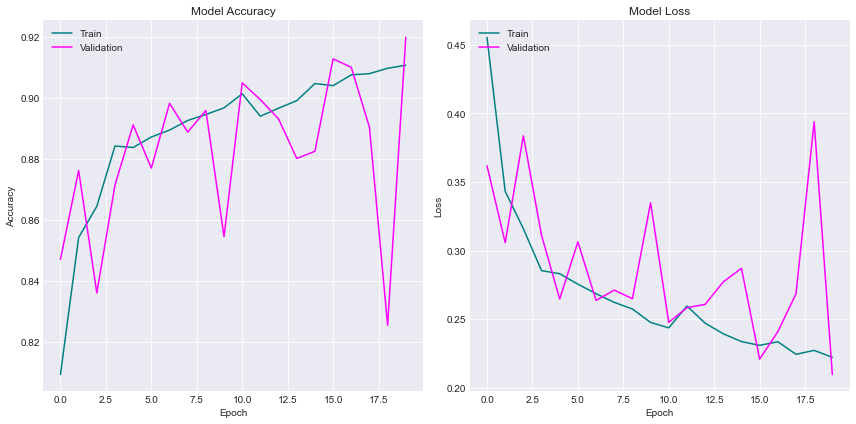

In [102]:
# Set the style
plt.style.use('seaborn-darkgrid')

# Plot training history for accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot for accuracy
plt.plot(history_aug_initial.history['accuracy'], color='teal')  # Teal
plt.plot(history_aug_initial.history['val_accuracy'], color='magenta')  # Pink
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training history for loss
plt.subplot(1, 2, 2)  # Subplot for loss
plt.plot(history_aug_initial.history['loss'], color='teal')  # Teal
plt.plot(history_aug_initial.history['val_loss'], color='magenta')  # Pink
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [103]:
# Evaluate the augmented data & initial model on the test data
test_loss_aug_initial, test_accuracy_aug_initial = initial_model.evaluate(test_generator_augmented)

# Print test loss and accuracy
print("Test Loss (Initial Model with Augmented Data):", test_loss_aug_initial)
print("Test Accuracy (Initial Model with Augmented Data):", test_accuracy_aug_initial)

59/59 [==============================] - 18s 307ms/step - loss: 0.6959 - accuracy: 0.6979
Test Loss (Initial Model with Augmented Data): 0.69588303565979
Test Accuracy (Initial Model with Augmented Data): 0.6979110836982727


The augmentation of the dataset has notably improved the model's performance, as evidenced by the increase in test accuracy from approximately 66.6% to 70.2%. This improvement suggests a reduction in overfitting, wherein the model becomes more adept at generalizing to unseen data. 

To further enhance performance and address any residual overfitting, we explored additional strategies such as hyperparameter tuning, including regularization dropout. Iterating through various combinations of hyperparameters such as epochs, learning rates, and dropout rates, we aimed to achieve a more consistent convergence between accuracy and loss. By systematically evaluating different configurations using ParameterGrid, we identified the best hyperparameters that resulted in the highest validation accuracy, ensuring optimal model performance.

In [37]:
# Define model parameters
img_size = (224, 224, 3)  # Image size: 224x224 pixels with 3 channels (RGB)

# Define hyperparameters range
param_grid = {
    'epochs': [10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.0, 0.25, 0.5],
}

best_accuracy = 0
best_params = {}

# Iterate through all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    # Define the model
    hp_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=img_size),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with specific learning rate
    optimizer = Adam(learning_rate=params['learning_rate'])
    hp_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = hp_model.fit(train_generator_augmented, epochs=params['epochs'], validation_data=validation_generator_augmented)
    
    # Get the validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Check if this model is the best so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Epoch 1/10
317/317 [==============================] - 232s 728ms/step - loss: 0.5585 - accuracy: 0.6957 - val_loss: 0.3798 - val_accuracy: 0.8352
Epoch 2/10
317/317 [==============================] - 224s 706ms/step - loss: 0.3941 - accuracy: 0.8260 - val_loss: 0.4177 - val_accuracy: 0.8103
Epoch 3/10
317/317 [==============================] - 228s 718ms/step - loss: 0.3552 - accuracy: 0.8464 - val_loss: 0.3487 - val_accuracy: 0.8506
Epoch 4/10
317/317 [==============================] - 220s 692ms/step - loss: 0.3476 - accuracy: 0.8495 - val_loss: 0.3272 - val_accuracy: 0.8628
Epoch 5/10
317/317 [==============================] - 217s 685ms/step - loss: 0.3313 - accuracy: 0.8561 - val_loss: 0.3220 - val_accuracy: 0.8644
Epoch 6/10
317/317 [==============================] - 225s 710ms/step - loss: 0.3279 - accuracy: 0.8630 - val_loss: 0.3130 - val_accuracy: 0.8687
Epoch 7/10
317/317 [==============================] - 225s 710ms/step - loss: 0.3181 - accuracy: 0.8659 - val_loss: 0.3090 -

The initial CNN model comprised three convolutional layers followed by max-pooling layers, a flattening layer, and two densely connected layers for binary classification. Initially trained for 20 epochs, the model utilized default settings for the learning rate (0.001) and dropout rate (0.0). Following hyperparameter tuning, the optimal parameters were identified as 20 epochs, a learning rate of 0.001, and a dropout rate of 0.25. These adjustments were implemented to continue alleviating the risk overfitting and enhance generalization performance. With the updated model, we anticipate improved accuracy on unseen data, attributed to the optimized hyperparameters and reduced risk of overfitting.

In [116]:
# Best Hyperparameters: {'dropout_rate': 0.25, 'epochs': 20, 'learning_rate': 0.001}

# Define the best hyperparameters
best_epochs = 20
best_learning_rate = 0.001
best_dropout_rate = 0.25

# Define the model with the best hyperparameters
hp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(best_dropout_rate),
    Dense(1, activation='sigmoid')
])

# Compile the model with the best hyperparameters
optimizer = Adam(learning_rate=best_learning_rate)
hp_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history_best = hp_model.fit(train_generator_augmented,
                          epochs=best_epochs,
                          validation_data=validation_generator_augmented)

Epoch 1/20
317/317 [==============================] - 212s 667ms/step - loss: 0.5914 - accuracy: 0.6706 - val_loss: 0.4390 - val_accuracy: 0.8269
Epoch 2/20
317/317 [==============================] - 209s 659ms/step - loss: 0.4098 - accuracy: 0.8262 - val_loss: 0.3353 - val_accuracy: 0.8600
Epoch 3/20
317/317 [==============================] - 207s 652ms/step - loss: 0.3814 - accuracy: 0.8362 - val_loss: 0.3285 - val_accuracy: 0.8640
Epoch 4/20
317/317 [==============================] - 212s 669ms/step - loss: 0.3604 - accuracy: 0.8512 - val_loss: 0.3220 - val_accuracy: 0.8632
Epoch 5/20
317/317 [==============================] - 210s 662ms/step - loss: 0.3447 - accuracy: 0.8530 - val_loss: 0.4462 - val_accuracy: 0.7839
Epoch 6/20
317/317 [==============================] - 205s 645ms/step - loss: 0.3460 - accuracy: 0.8569 - val_loss: 0.3079 - val_accuracy: 0.8722
Epoch 7/20
317/317 [==============================] - 197s 621ms/step - loss: 0.3296 - accuracy: 0.8603 - val_loss: 0.3003 -

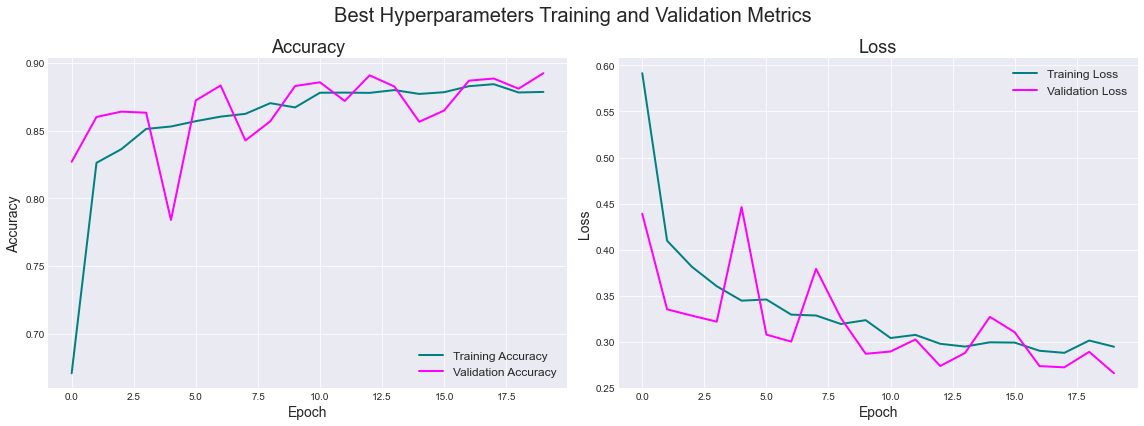

In [117]:
# Set the style
plt.style.use('seaborn-darkgrid')

# Create the plots
plt.figure(figsize=(16, 6))

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_best.history['accuracy'], color='teal', label='Training Accuracy', linewidth=2)
plt.plot(history_best.history['val_accuracy'], color='magenta', label='Validation Accuracy', linewidth=2)
plt.title('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_best.history['loss'], color='teal', label='Training Loss', linewidth=2)
plt.plot(history_best.history['val_loss'], color='magenta', label='Validation Loss', linewidth=2)
plt.title('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Title
plt.suptitle('Best Hyperparameters Training and Validation Metrics', fontsize=20)

plt.tight_layout()
plt.show()

In [118]:
# Evaluate the best model on the test data
test_loss_best, test_accuracy_best = hp_model.evaluate(test_generator_augmented)
print("Test Loss:", test_loss_best)
print("Test Accuracy:", test_accuracy_best)

59/59 [==============================] - 21s 355ms/step - loss: 0.7497 - accuracy: 0.6834
Test Loss: 0.749701976776123
Test Accuracy: 0.683449387550354


We then moved to implement early stopping. By conducting hyperparameter tuning before implementing early stopping, we ensure that the model is already optimized in terms of architecture and hyperparameters. Early stopping then acts as an additional regularization mechanism to prevent overfitting and improve the model's generalization ability. This sequential approach optimizes both the architecture and regularization strategies of the model for better overall performance.

In [108]:
hp_model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
                 metrics=['accuracy'])  # Monitor accuracy during training

# Define early stopping callback to prevent overfitting and reduce training time
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the hyperparameter-tuned model
history_es = hp_model.fit(train_generator_augmented,
                          epochs=best_epochs,
                          validation_data=validation_generator_augmented,
                          callbacks=[early_stopping])

Epoch 1/20
317/317 [==============================] - 194s 611ms/step - loss: 0.3579 - accuracy: 0.8473 - val_loss: 0.3503 - val_accuracy: 0.8490
Epoch 2/20
317/317 [==============================] - 194s 610ms/step - loss: 0.3359 - accuracy: 0.8587 - val_loss: 0.3678 - val_accuracy: 0.8383
Epoch 3/20
317/317 [==============================] - 194s 610ms/step - loss: 0.3332 - accuracy: 0.8567 - val_loss: 0.3358 - val_accuracy: 0.8647
Epoch 4/20
317/317 [==============================] - 194s 610ms/step - loss: 0.3321 - accuracy: 0.8602 - val_loss: 0.3289 - val_accuracy: 0.8624
Epoch 5/20
317/317 [==============================] - 193s 609ms/step - loss: 0.3356 - accuracy: 0.8569 - val_loss: 0.3198 - val_accuracy: 0.8726
Epoch 6/20
317/317 [==============================] - 193s 607ms/step - loss: 0.3267 - accuracy: 0.8631 - val_loss: 0.3149 - val_accuracy: 0.8679
Epoch 7/20
317/317 [==============================] - 193s 608ms/step - loss: 0.3267 - accuracy: 0.8624 - val_loss: 0.3205 -

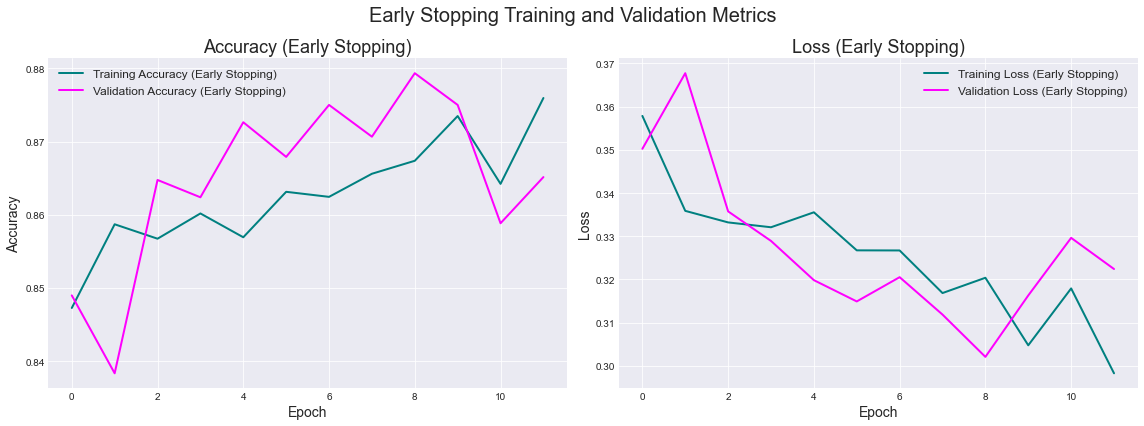

In [109]:
# Set the style
plt.style.use('seaborn-darkgrid')

# Create the plots
plt.figure(figsize=(16, 6))

# Plot training and validation accuracy (Early Stopping)
plt.subplot(1, 2, 1)
plt.plot(history_es.history['accuracy'], color='teal', label='Training Accuracy (Early Stopping)', linewidth=2)
plt.plot(history_es.history['val_accuracy'], color='magenta', label='Validation Accuracy (Early Stopping)', linewidth=2)
plt.title('Accuracy (Early Stopping)', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training and validation loss (Early Stopping)
plt.subplot(1, 2, 2)
plt.plot(history_es.history['loss'], color='teal', label='Training Loss (Early Stopping)', linewidth=2)
plt.plot(history_es.history['val_loss'], color='magenta', label='Validation Loss (Early Stopping)', linewidth=2)
plt.title('Loss (Early Stopping)', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Title
plt.suptitle('Early Stopping Training and Validation Metrics', fontsize=20)

plt.tight_layout()
plt.show()

In [111]:
# Evaluate the hyperparameter-tuned model on the test data
test_loss_es, test_accuracy_es = hp_model.evaluate(test_generator_augmented)
print("Test Loss:", test_loss_es)
print("Test Accuracy:", test_accuracy_es)

59/59 [==============================] - 18s 302ms/step - loss: 0.7022 - accuracy: 0.6765
Test Loss: 0.7022153735160828
Test Accuracy: 0.6764863133430481


Following early stopping, we proceeded to implement k-fold cross-validation. This additional step further refines the model by providing a more comprehensive evaluation of its performance across different subsets of the data. By averaging results over multiple folds, k-fold cross-validation enhances the reliability and robustness of the model evaluation process, ensuring better-informed decisions.

In [79]:
# Define the number of folds for cross-validation
k = 5

# Initialize lists to store validation metrics across folds
val_losses = []
val_accuracies = []

# Initialize k-fold cross-validation
kf = KFold(n_splits=k)

# Perform k-fold cross-validation
for train_index, val_index in kf.split(train_generator_augmented):
    # Clone the model for each fold to ensure a fresh copy
    fold_model = clone_model(hp_model)
    fold_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Initialize generators for training and validation data
    train_generator_fold = train_generator_augmented
    val_generator_fold = validation_generator_augmented
    
    # Train the model on this fold
    history = fold_model.fit(train_generator_fold, epochs=best_epochs, callbacks=[early_stopping], validation_data=val_generator_fold)
    
    # Evaluate the model on the validation data for this fold
    val_loss, val_accuracy = fold_model.evaluate(val_generator_fold)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/20
317/317 [==============================] - 219s 688ms/step - loss: 0.5262 - accuracy: 0.7252 - val_loss: 0.4475 - val_accuracy: 0.8084
Epoch 2/20
317/317 [==============================] - 218s 688ms/step - loss: 0.4042 - accuracy: 0.8237 - val_loss: 0.3914 - val_accuracy: 0.8320
Epoch 3/20
317/317 [==============================] - 220s 695ms/step - loss: 0.3696 - accuracy: 0.8388 - val_loss: 0.3380 - val_accuracy: 0.8612
Epoch 4/20
317/317 [==============================] - 205s 645ms/step - loss: 0.3405 - accuracy: 0.8596 - val_loss: 0.3213 - val_accuracy: 0.8655
Epoch 5/20
317/317 [==============================] - 203s 640ms/step - loss: 0.3238 - accuracy: 0.8618 - val_loss: 0.3077 - val_accuracy: 0.8726
Epoch 6/20
317/317 [==============================] - 203s 641ms/step - loss: 0.3288 - accuracy: 0.8605 - val_loss: 0.3024 - val_accuracy: 0.8754
Epoch 7/20
317/317 [==============================] - 201s 635ms/step - loss: 0.3140 - accuracy: 0.8687 - val_loss: 0.3249 -

In [80]:
# Calculate and print average validation metrics across folds
avg_val_loss_cv = np.mean(val_losses)
avg_val_accuracy_cv = np.mean(val_accuracies)
print("Average Validation Loss (CV):", avg_val_loss_cv)
print("Average Validation Accuracy (CV):", avg_val_accuracy_cv)

Average Validation Loss (CV): 0.3080347657203674
Average Validation Accuracy (CV): 0.8709779024124146


After the enhancements including data augmentation, hyperparameter tuning with dropout regularization, early stopping, and k-fold cross-validation, we observed meaningful improvements and are ready to construct our final model.

In [82]:
# # Final Model 

# Now that cross-validation is done, you can use the hp_model for building the final model
final_model = clone_model(hp_model)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the final model using the entire augmented training dataset, implementing early stopping, and utilizing the validation fold
final_model.fit(train_generator_augmented, callbacks=[early_stopping], epochs=best_epochs, validation_data=val_generator_fold)

# Evaluate the final model on the test data
final_loss, final_accuracy = final_model.evaluate(test_generator_augmented)
print("Final Test Loss:", final_loss)
print("Final Test Accuracy:", final_accuracy)

Epoch 1/20
317/317 [==============================] - 215s 675ms/step - loss: 0.5745 - accuracy: 0.6758 - val_loss: 0.4348 - val_accuracy: 0.7969
Epoch 2/20
317/317 [==============================] - 214s 676ms/step - loss: 0.4041 - accuracy: 0.8218 - val_loss: 0.3415 - val_accuracy: 0.8549
Epoch 3/20
317/317 [==============================] - 217s 685ms/step - loss: 0.3657 - accuracy: 0.8414 - val_loss: 0.3463 - val_accuracy: 0.8565
Epoch 4/20
317/317 [==============================] - 203s 639ms/step - loss: 0.3519 - accuracy: 0.8534 - val_loss: 0.3576 - val_accuracy: 0.8478
Epoch 5/20
317/317 [==============================] - 204s 642ms/step - loss: 0.3506 - accuracy: 0.8508 - val_loss: 0.3150 - val_accuracy: 0.8679
Epoch 6/20
317/317 [==============================] - 202s 637ms/step - loss: 0.3485 - accuracy: 0.8555 - val_loss: 0.3423 - val_accuracy: 0.8557
Epoch 7/20
317/317 [==============================] - 200s 631ms/step - loss: 0.3350 - accuracy: 0.8594 - val_loss: 0.3402 -

To observe how our final model generates predictions, we generated 10 predictions using the model and visualized them alongside their corresponding actual labels.

1/1 [==============================] - 0s 159ms/step


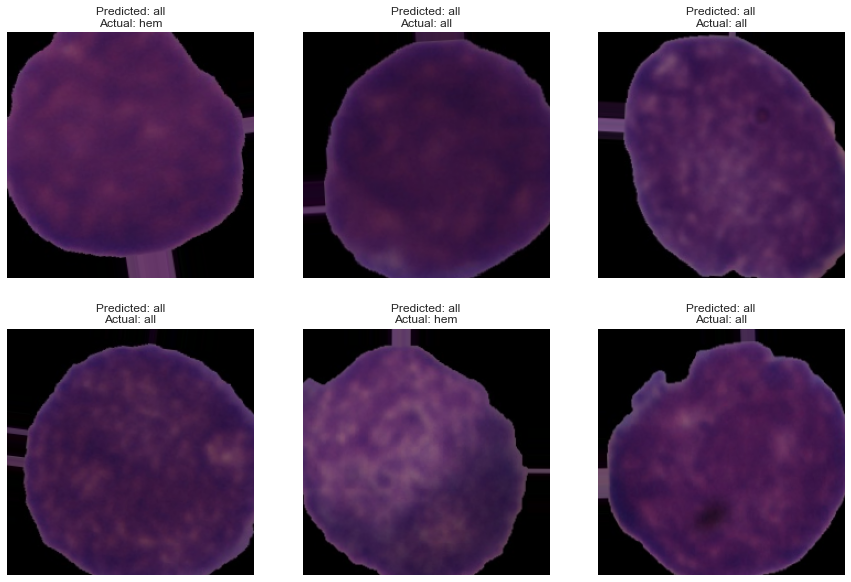

In [126]:
# Generate 6 predictions using the final model
num_predictions = 6
predicted_labels = []
actual_labels = []

plt.figure(figsize=(15, 10))

# Counter to track the number of predictions generated
prediction_count = 0

for i in range(len(test_generator_augmented)):
    # Break out of the loop if the desired number of predictions is reached
    if prediction_count >= num_predictions:
        break
    
    # Get a batch of images and their labels from the test generator
    images, labels = test_generator_augmented[i]

    # Generate predictions for the batch of images
    batch_predictions = final_model.predict(images)

    # Convert the predicted labels from probabilities to binary labels ('hem' or 'all')
    batch_predicted_labels = np.round(batch_predictions).flatten().astype(int)
    batch_predicted_labels = ['hem' if label == 1 else 'all' for label in batch_predicted_labels]

    # Convert the actual labels from numeric to string labels ('hem' or 'all')
    batch_actual_labels = ['hem' if label == 1 else 'all' for label in labels]

    # Extend the list of predicted and actual labels
    predicted_labels.extend(batch_predicted_labels)
    actual_labels.extend(batch_actual_labels)

    # Plot the images along with their predicted and actual labels
    for j in range(len(images)):
        # Increment the prediction count
        prediction_count += 1
        
        # Plot the image and its predicted and actual labels
        plt.subplot(2, 3, prediction_count % num_predictions + 1)  # Adjusted subplot index using modulo
        plt.imshow(images[j])
        plt.title(f'Predicted: {batch_predicted_labels[j]}\nActual: {batch_actual_labels[j]}')
        plt.axis('off')

plt.show()


After completing six iterations of model refinement, we aimed to visualize the evolution of our model's performance across each step. By plotting the changes in key metrics such as test loss and accuracy, we sought to gain a clearer understanding of how each refinement stage contributed to overall improvement. This visualization not only provides a comprehensive overview of our model's progress but also helps in identifying which refinement techniques were most effective in enhancing its performance.

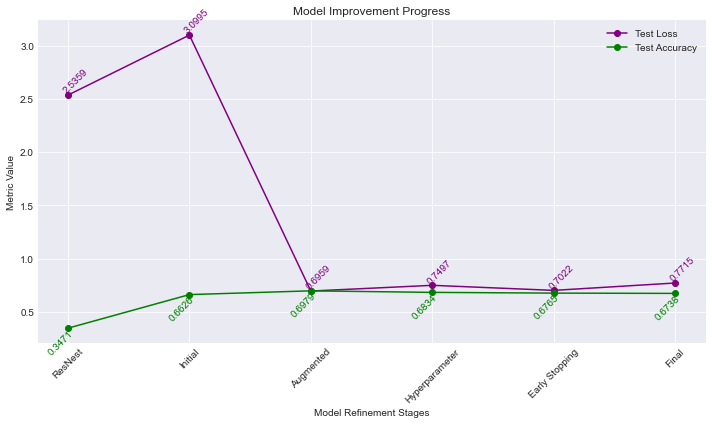

In [150]:
# Compile 6 model stage data
stages = ['ResNest', 'Initial', 'Augmented', 'Hyperparameter', 'Early Stopping', 'Final']
test_loss = [test_resnet_loss, test_loss_initial, test_loss_aug_initial, test_loss_best, test_loss_es, final_loss]
test_accuracy = [test_resnet_accuracy, test_accuracy_initial, test_accuracy_aug_initial, test_accuracy_best, test_accuracy_es, final_accuracy]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(stages, test_loss, marker='o', color='#800080', label='Test Loss')  # Dark purple color
plt.plot(stages, test_accuracy, marker='o', color='green', label='Test Accuracy')

plt.title('Model Improvement Progress')
plt.xlabel('Model Refinement Stages')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Annotate the points with values
for i, (x, y1, y2) in enumerate(zip(stages, test_loss, test_accuracy)):
    plt.text(x, y1, f'{y1:.4f}', ha='left', va='bottom', fontsize=10, color='#800080', rotation=45, rotation_mode='anchor')  # Dark purple color
    plt.text(x, y2, f'{y2:.4f}', ha='right', va='top', fontsize=10, color='green', rotation=45, rotation_mode='anchor')

plt.tight_layout()
plt.show()

Throughout our model refinement process, we achieved significant success in optimizing our training and validation sets. These efforts appeared to effectively mitigate concerns related to overfitting, yielding a reasonably accurate predictive model within these groups. However, consistent challenges were encountered when assessing the model's performance on the separate test dataset. Despite incremental improvements during each stage of refinement, the test set's accuracy and loss metrics did not align with those of the training and validation sets. Notably, the test set comprised an entirely distinct group of patients, highlighting potential issues of generalization. With a dataset of limited size (73 patients in training/validation and 28 in the test set), it's evident that broader data scope is needed, encompassing diverse demographics, cancer stages, and treatment statuses. Collaborating with domain experts to identify specific cell features beyond image cropping could further enhance our model's discriminatory capabilities. While our refinement efforts have yielded striking improvements, further enhancements are essential for real-world deployment.